In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
import random
import matplotlib.pyplot as plt

In [57]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [67]:
# class Network(nn.Module):

#     def __init__(self):
#         super().__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(1, 8, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(8, 16, kernel_size=3, padding=1),
#             nn.ReLU()
#         )
#         self.fc = nn.Sequential(
#             nn.Linear(16*6*6 + 2, 32),
#             nn.ReLU(),
#             nn.Linear(32, 4),
#         )

#     def forward(self, r, c, visit_grid):
#         visit_grid = torch.tensor(visit_grid, dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 36.0
#         conv_out = self.conv(visit_grid).view(1, -1)
#         pos = torch.tensor([r/5, c/5], dtype=torch.float32).unsqueeze(0)
#         x = torch.cat([conv_out, pos], dim=1)
#         logits = self.fc(x)
#         return Categorical(logits=logits)


class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 4),  # 4 actions
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        probs = self.fc(x)
        return torch.distributions.Categorical(probs)


In [68]:
lr = 1e-3
model = Network()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [116]:
def env_step(r,c,action):
  # 0 up, 1 down, 2 left, 3 right
  if action == 0:
    r = max(0,r-1)
  elif action == 1:
    r = min(r+1,5)
  elif action == 2:
    c = max(0,c-1)
  elif action == 3:
    c = min(c+1,5)
  return r,c

def find_reward(r,c,state_visitation):
  state_visitation[r][c] += 1
  if(state_visitation[r][c] == 1):
    return 10
  else:
    return 0

In [117]:
gamma = 0.99
epoches = 1000

In [118]:
reward_plot = []
cnt = 0
for epoch in range(epoches):
  r = 5
  c = 0
  action_log_prob = []
  rewards = []
  state_visitation = [[0 for _ in range(6)] for _ in range(6)]
  episode_reward = 0
  for t in range(36):
    # dist = model(r, c)
    dist = model(torch.tensor([r, c], dtype=torch.float32))
    action = dist.sample()
    if(action == 2):
      cnt+=1
    r,c = env_step(r,c,action.item())
    reward = find_reward(r,c,state_visitation)
    episode_reward += reward
    rewards.append(reward)
    action_log_prob.append(dist.log_prob(action))

  discounted = 0
  reward_to_go = []
  for reward in reversed(rewards):
    discounted = reward + gamma * discounted
    reward_to_go.insert(0,torch.tensor(discounted))

  reward_to_go = torch.stack(reward_to_go)
  reward_to_go = (reward_to_go - reward_to_go.mean()) / (reward_to_go.std() + 1e-8)
  entropy = dist.entropy().mean()
  loss = -1*torch.sum(torch.stack(action_log_prob)*reward_to_go) + 0.02*entropy
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  reward_plot.append(episode_reward)
  if(epoch%100 == 0):
    print(episode_reward)

10
30
190
160
140
170
150
130
150
170


In [122]:
# ok not exporing enough.
# paile kunai actions le ramro reward aako jasto lagyo, ani tei liyo. this is not good.
# let's make it explore more
# how do it? as this is online rl
# add entropy term in the loss


# why so low reward? ok, this is the case
# 1. it's action is really stocastic so even if it has learned policy, the policy is still little stocastic
# 2. so it don't know the past actions,
# 3. so i think this is the best we can get without incorporating memory.


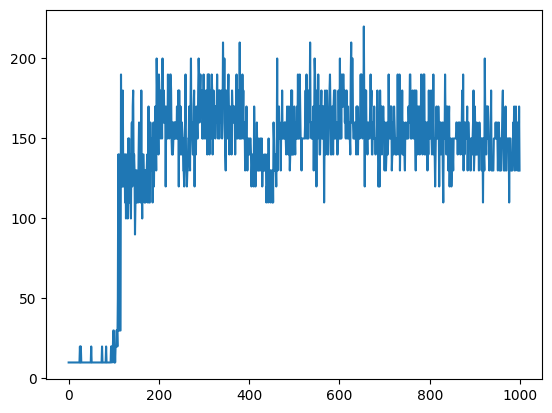

In [120]:
import matplotlib.pyplot as plt
plt.plot(reward_plot)
plt.show()

In [121]:
r = 5
c = 0
print(r,c)
state_visitation = [[0 for _ in range(6)] for _ in range(6)]
for t in range(36):
    # dist = model(r, c)
    dist = model(torch.tensor([r, c], dtype=torch.float32))
    action = dist.sample()
    r,c = env_step(r,c,action.item())
    reward = find_reward(r,c,state_visitation)
    print(action,reward)
    rewards.append(reward)
    action_log_prob.append(dist.log_prob(action))

5 0
tensor(0) 10
tensor(0) 10
tensor(0) 10
tensor(0) 10
tensor(3) 10
tensor(3) 10
tensor(3) 10
tensor(1) 10
tensor(0) 0
tensor(3) 10
tensor(1) 10
tensor(3) 10
tensor(1) 10
tensor(1) 10
tensor(1) 10
tensor(1) 0
tensor(1) 0
tensor(1) 0
tensor(1) 0
tensor(1) 0
tensor(1) 0
tensor(1) 0
tensor(1) 0
tensor(1) 0
tensor(1) 0
tensor(1) 0
tensor(1) 0
tensor(1) 0
tensor(0) 0
tensor(1) 0
tensor(1) 0
tensor(1) 0
tensor(1) 0
tensor(3) 0
tensor(1) 0
tensor(1) 0
